In [1]:
# Importing Libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import Functions as Fc

from numba import jit
from matplotlib.pyplot import figure
from scipy import signal
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from importlib import reload
from scipy.fft import fft
from numpy import genfromtxt
reload(Fc)

<module 'Functions' from '/home/kyubin/UROP/NonLinearSystemAnalysis/Functions.py'>

In [2]:
os.getcwd()

'/home/kyubin/UROP/NonLinearSystemAnalysis'

In [3]:
# Simulate Nonlinear System
# Duffing oscillator with nonlinear damping
# x_ddot + cl*x_dot + cn*xdot^3 + kl*x + kn*x^3 = F
# The solve_ivp ODE solver is relatively slow so do not run this section of the code too frequently. Carry out
# Simulations in the matlab file. 

# Equation parameters
kl = 2e4
kn = 0*1e11
cl = 50
cn = 0*1e8

T = 200
dt = 2**-12
taxis = np.arange(0, T + dt, dt)
taxis = np.reshape(taxis, (len(taxis),))
F = 10 * np.random.normal(size=(len(taxis),))

# Initial condition
x0 = (0, 0)

# Simulating system using an ODE solver
Ft = interp1d(taxis, F, axis = 0)

start = time.time()

@jit(nopython=False) # Set "nopython" mode for best performance, equivalent to @njit
def fun(t, x):
    x1, x2 = x
    dx1dt = x2
    dx2dt = Ft(t) - cl*x2 - cn*x2**3 - kl*x1 - kn*x1**3
    return [dx1dt, dx2dt]


sol = solve_ivp(fun, (0, T), x0, t_eval=taxis)

x = sol.y[0]
end = time.time()
print(end - start)

/tmp/ipykernel_87/4202349658.py:27: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fun" failed type inference due to: Untyped global name 'Ft': Cannot determine Numba type of <class 'scipy.interpolate.interpolate.interp1d'>

File "../../../../tmp/ipykernel_87/4202349658.py", line 31:
<source missing, REPL/exec in use?>

  @jit(nopython=False) # Set "nopython" mode for best performance, equivalent to @njit
/home/kyubin/UROP/NonLinearSystemAnalysis/NonLinearSystemAnalysis_env/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "fun" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_87/4202349658.py", line 27:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/kyubin/UROP/NonLinearSystemAnalysis/NonLinearSystemAnalysis_env/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from 

206.3080439567566


In [5]:
data = np.vstack((taxis, F, x))
# np.savetxt("/mnt/c/Users/admin/Google Drive/urop_copy/duffing_oscillator_data/data.csv", data)

In [6]:
# Method 1: Estimate transfer function and PSDs manually according to Welch averaged periodogram method
nfft = 2**13 # Length of FFT

# Split F and X in to overlapping frames (50% overlap). Function defined in Functions.py
x_frames = Fc.FrameSplit(x, nfft)
F_frames = Fc.FrameSplit(F, nfft)

# Defining Hanning Window
win = np.hanning(nfft)

# Applying Hanning windows to frames
x_win = np.multiply(x_frames.transpose(), win).transpose()
F_win = np.multiply(F_frames.transpose(), win).transpose()

# Calculate Fourier transform
x_f = fft(x_win, axis = 0) * 2/nfft #  Divide by number of samples to scale amplitude according to the number of samples
F_f = fft(F_win, axis = 0) * 2/nfft #  Not entirely sure of the purpose of the 2

# RMS value of window:
W = math.sqrt(np.sum(win*win)/len(win))

# Calculating PSD using definition Syx = E(Y.X*), scaling factor to account for energy (1/w**2) and one sided (*2)
Sxx = np.sum(np.multiply(x_f, np.conj(x_f)), 1) / int(x_frames.shape[1]) * 2/W**2
Sff = np.sum(np.multiply(F_f, np.conj(F_f)), 1) / int(x_frames.shape[1]) * 2/W**2
Sxf = np.sum(np.multiply(x_f, np.conj(F_f)), 1) / int(x_frames.shape[1]) * 2/W**2

# Estimating Transfer function and coherence from Cxf and PSDs
Txf = Sxf / Sff

# Coherence
Cxf = np.abs(Sxf)**2/(Sxx * Sff)

# Setting the frequency axis using the sampling rate 
faxis = np.linspace(0, 1/dt, nfft+1)
faxis = faxis[0:int(nfft)]

In [7]:
f, tyx, cyx, syx, sxx, syy = Fc.tfest(F, x, nfft = nfft, Fs=1/dt)

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


In [8]:
# Analytical solution for linear section
Txf_a = 1 / (-(2*np.pi*faxis)**2 + cl*complex(0, 1)*(2*np.pi*faxis) + kl)

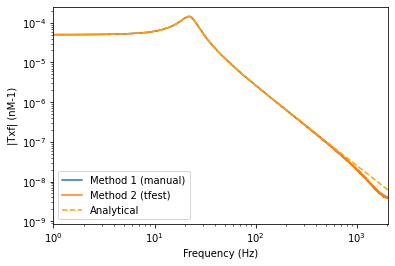

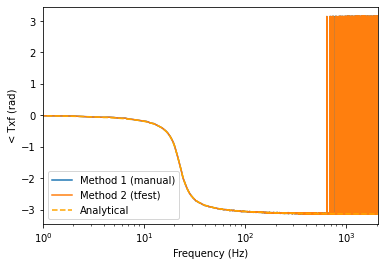

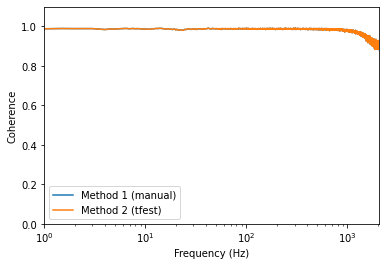

In [9]:
# Plotting the different methods

Xlim = (1, 1/dt/2)

plt.loglog(faxis, np.abs(Txf), label='Method 1 (manual)')
plt.semilogx(f, np.abs(tyx[0,0,:]), label='Method 2 (tfest)')
plt.semilogx(faxis, np.abs(Txf_a), label='Analytical', c='orange', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Txf| (nM-1)")
plt.xlim(Xlim)
plt.legend(loc=3)
plt.show()

plt.semilogx(faxis, np.angle(Txf), label='Method 1 (manual)')
plt.semilogx(f, np.angle(tyx[0,0,:]), label='Method 2 (tfest)')
plt.semilogx(faxis, np.angle(Txf_a), label='Analytical', c='orange', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("< Txf (rad)")
plt.xlim(Xlim)
plt.legend(loc=3)
plt.show()

plt.semilogx(faxis, abs(Cxf), label='Method 1 (manual)')
plt.semilogx(f, cyx[0,0,:], label='Method 2 (tfest)')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.xlim(Xlim)
plt.legend(loc=3)
plt.ylim((0, 1.1))
plt.show()

In [10]:
# Tesing multiple coherence with random output noise
noise = 10e-2*np.random.normal(size=(len(taxis),))

In [11]:
F_noise = np.vstack((F, noise)).transpose()
x_noise = x + noise

In [12]:
f, tyx, mcyx, syx, sxx, syy = Fc.tfest(F_noise, x_noise, nfft = nfft, Fs=1/dt)

Calculating Sxx
Calculating Syy
Calculating Syx
Calculating transfer function and coherence


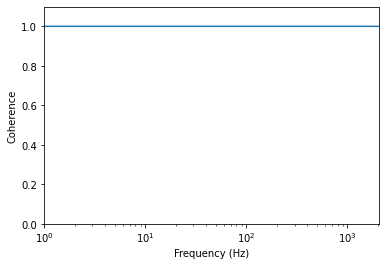

In [13]:
plt.semilogx(f, mcyx[0,0,:])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.xlim(Xlim)
plt.ylim((0, 1.1))
plt.show()

In [14]:
F_noise.shape

(819201, 2)

In [15]:
x_noise.shape

(819201,)